# Forward and Backward Process

In this notebook, we explore what the decoder is capable of doing with:  
1. A single image that has been noised at a specific step in the diffusion process
2. A full sequence of progressively noised images across all diffusion steps

## Setup
We begin by importing the necessary libraries and loading the pretrained diffusion model and scheduler.

In [1]:
# Importing necessary libraries
from functions import *
import torch
import diffusers
from PIL import Image
from tqdm import tqdm

In [ ]:
# setup
model_id = config("model")
model = diffusers.UNet2DModel.from_pretrained(model_id)
scheduler = diffusers.DDIMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(config("model.timesteps"))
num_sampling_steps = config("forward.timestep")

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Denoising a noised image

We start by loading an image and converting it into a tensor.  
Then we simulate the forward prcess by adding noise to it at a specific timestep (forward_timestep_index).  
Finally, we apply the decoder (reverse process) to try to reconstruct the original image from the noised version.  

In [ ]:
# Loading and transforming an image
original_image = Image.open("../images/ddpm_9.png")
original_image = image_as_tensor(original_image)

# input prepraration
image_size = model.config.sample_size # get image size
initial_noise_tensor = generate_noise(image_size) # sample random noise

We add noise to the image at a chose timestep in the diffusion process:

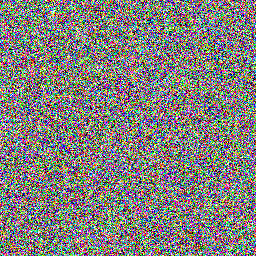

In [ ]:
# forward process
noised_image = scheduler.add_noise(original_image, initial_noise_tensor, scheduler.timesteps[num_sampling_steps])
tensor_as_image(noised_image)

We iteratively apply the decoder to remove noise and reconstruct the image step by step:

""

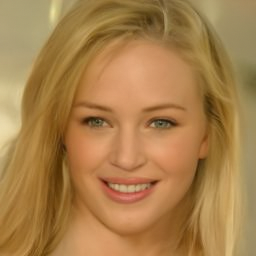

100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


In [ ]:
# backward process
current = noised_image
for t in tqdm(scheduler.timesteps[num_sampling_steps:]):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        show_images(current)

We then compare the original image, the reconstructed image, and their difference to evaluate how well the model recovers lost information.

,,

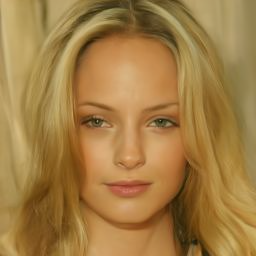
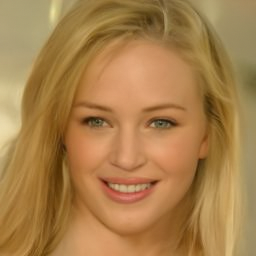
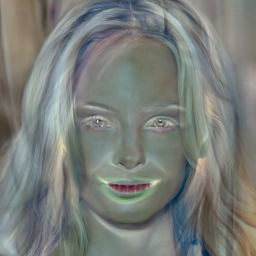

In [16]:
# compare images
show_images(original_image, current, original_image - current)

## Noise Accumulation and Decoder Output at Each Step

The following code generates a large image that visualizes how information is gradually lost through the progressive addition of noise during the diffusion process.

- The first column shows the original image as processed by the encoder  
- Each subsequent column displays the output of the decoder applied to increasingly noised versions of the image  
- Each row corresponds to a specific step in the noise schedule: the further down, the more noise has been added before decoding. 

This visualization illustrates how, step by step, information degrades due to noise - and how the decoder's ability to recover the original image decreases as the input becomes more corrupted.

In [ ]:
# setup output image
output = Image.new("RGB", (image_size * num_sampling_steps, image_size * num_sampling_steps), (255, 255, 255))
output.paste(tensor_as_image(original_image), (0, 0))

# output generation
with tqdm(total=sum(range(1, num_sampling_steps + 1))) as tqdm_bar:
    for i in reversed(range(num_sampling_steps)):
        sampled_noise = generate_noise(image_size)
        current = scheduler.add_noise(original_image, sampled_noise, scheduler.timesteps[i])
        output.paste(tensor_as_image(current), (0, image_size * (num_sampling_steps - i)))
        for j, t in enumerate(scheduler.timesteps[i:]):
            with torch.no_grad():
                predicted_noise = model(current, t).sample
                current = scheduler.step(predicted_noise, t, current).prev_sample
                output.paste(tensor_as_image(current), (image_size * (j + 1), image_size * (num_sampling_steps - i)))
            tqdm_bar.update(1)

# save output image
output.save("../output/process.png")

  7%|▋         | 14/210 [00:28<06:34,  2.01s/it]


KeyboardInterrupt: 